In [4]:
import pandas as pd
import geopandas as gpd
from shapely import geometry
import rasterio
import mercantile
from tqdm import tqdm
import os
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import geodatasets
import contextily as cx
import geopandas

# Description Notebook Goal

## Step 1 - Define our area of interest (AOI)

We define our area of interest (or AOI) as a GeoJSON geometry, then use the `shapely` library to get the bounding box.

In [5]:
# Example of converting coordinates (x1, y1), (x2, y2), (x3, y3), (x4, y4), (x1, y1), to bounds of interest: 
# Geometry copied from https://geojson.io

# Longitude & Lattitude min/max are tacken from 'Challenge_2024_Landsat_NDVI' notebook
min_lon = -66.19385887
min_lat = 18.27306794
max_lon = -66.08007533
max_lat = 18.48024350

aoi_geom = {
    "coordinates": [
        [
            [min_lon, min_lat],
            [max_lon, min_lat],
            [max_lon, max_lat],
            [min_lon, max_lat],
            [min_lon, min_lat],
        ]
    ],
    "type": "Polygon",
}

aoi_shape = geometry.shape(aoi_geom)
minx, miny, maxx, maxy = aoi_shape.bounds

output_fn = "example_building_footprints.geojson"

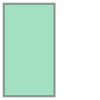

In [6]:
aoi_shape

In [7]:
minx, miny, maxx, maxy

(-66.19385887, 18.27306794, -66.08007533, 18.4802435)

## Step 2 - Determine which tiles intersect our AOI

In [8]:
quad_keys = set()
for tile in list(mercantile.tiles(minx, miny, maxx, maxy, zooms=9)):
    quad_keys.add(mercantile.quadkey(tile))
quad_keys = list(quad_keys)
print(f"The input area spans {len(quad_keys)} tiles: {quad_keys}")

The input area spans 2 tiles: ['032300212', '032300203']


## Step 3 - Download the building footprints for each tile that intersects our AOI and crop the results

This is where most of the magic happens. We download all the building footprints for each tile that intersects our AOI, then only keep the footprints that are _contained_ by our AOI.

*Note*: this step might take awhile depending on how many tiles your AOI covers and how many buildings footprints are in those tiles.

In [9]:
df = pd.read_csv(
    "https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv", dtype=str
)
df.head()

,Location,QuadKey,Url,Size
0,Abyei,122321003,https://minedbuildings.blob.core.windows.net/g...,4.8KB
1,Abyei,122321021,https://minedbuildings.blob.core.windows.net/g...,7.9KB
2,Afghanistan,123011320,https://minedbuildings.blob.core.windows.net/g...,70.1KB
3,Afghanistan,123011321,https://minedbuildings.blob.core.windows.net/g...,1.3MB
4,Afghanistan,123011322,https://minedbuildings.blob.core.windows.net/g...,4.1MB


In [10]:
# Check all tiles related to PuertoRico location
df[df['Location'] == 'PuertoRico']

,Location,QuadKey,Url,Size
19556,PuertoRico,032300202,https://minedbuildings.blob.core.windows.net/g...,24.8MB
19557,PuertoRico,032300203,https://minedbuildings.blob.core.windows.net/g...,48.0MB
19558,PuertoRico,032300212,https://minedbuildings.blob.core.windows.net/g...,33.6MB
19559,PuertoRico,032300213,https://minedbuildings.blob.core.windows.net/g...,127.9KB
19560,PuertoRico,032300220,https://minedbuildings.blob.core.windows.net/g...,741.4KB
19561,PuertoRico,032300221,https://minedbuildings.blob.core.windows.net/g...,1.8MB
19562,PuertoRico,032300230,https://minedbuildings.blob.core.windows.net/g...,499.7KB


In [11]:
idx = 0
combined_gdf = gpd.GeoDataFrame()
with tempfile.TemporaryDirectory() as tmpdir:
    # Download the GeoJSON files for each tile that intersects the input geometry
    tmp_fns = []
    for quad_key in tqdm(quad_keys):
        rows = df[df["QuadKey"] == quad_key]
        if rows.shape[0] == 1:
            url = rows.iloc[0]["Url"]

            df2 = pd.read_json(url, lines=True)
            df2["geometry"] = df2["geometry"].apply(geometry.shape)

            gdf = gpd.GeoDataFrame(df2, crs=4326)
            fn = os.path.join(tmpdir, f"{quad_key}.geojson")
            tmp_fns.append(fn)
            if not os.path.exists(fn):
                gdf.to_file(fn, driver="GeoJSON")
        elif rows.shape[0] > 1:
            raise ValueError(f"Multiple rows found for QuadKey: {quad_key}")
        else:
            raise ValueError(f"QuadKey not found in dataset: {quad_key}")

    # Merge the GeoJSON files into a single file
    for fn in tmp_fns:
        gdf = gpd.read_file(fn)  # Read each file into a GeoDataFrame
        gdf = gdf[gdf.geometry.within(aoi_shape)]  # Filter geometries within the AOI
        gdf['id'] = range(idx, idx + len(gdf))  # Update 'id' based on idx
        idx += len(gdf)
        combined_gdf = pd.concat([combined_gdf,gdf],ignore_index=True)

100%|██████████| 2/2 [01:36<00:00, 48.43s/it]


## Step 4 - Save the resulting footprints to file
* Source for EPSG code: https://epsg.io/3920#:~:text=Puerto%20Rico%20%2F%20UTM%20zone%2020N%20%2D%20EPSG%3A3920
* Explanation for EPSG codes: https://gis.stackexchange.com/questions/410958/geopandas-warnings-unless-wrong-epsg-is-used

In [12]:
combined_projected= combined_gdf.to_crs(epsg=3920)

In [13]:
combined_projected['area'] = combined_projected.area
combined_projected['area']

0          84.012766
1          19.078487
2          97.400150
3          50.103971
4         190.802668
             ...    
131340    130.155801
131341    165.216650
131342    267.666962
131343    132.932861
131344    148.293447
Name: area, Length: 131345, dtype: float64

In [14]:
combined_projected.crs

<Projected CRS: EPSG:3920>
Name: Puerto Rico / UTM zone 20N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: British Virgin Islands - onshore - Anegada, Jost Van Dyke, Tortola, and Virgin Gorda.
- bounds: (-64.88, 18.28, -64.25, 18.78)
Coordinate Operation:
- name: UTM zone 20N
- method: Transverse Mercator
Datum: Puerto Rico
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

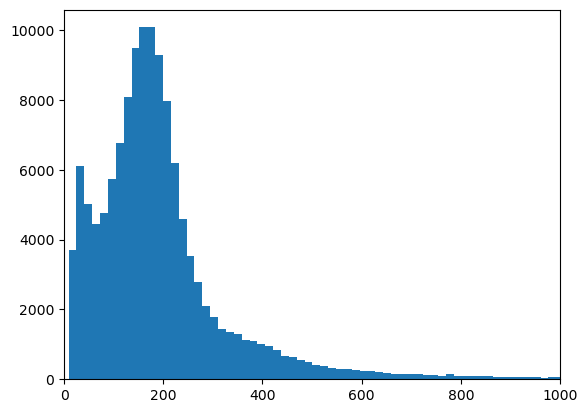

In [15]:
plt.hist(combined_projected['area'], bins = 3000)
plt.xlim(0, 1000)
plt.show()

In [16]:
combined_projected['area'].describe()

count    131345.000000
mean        237.741594
std         573.866440
min           9.012636
25%         111.797388
50%         169.848982
75%         233.403235
max       47595.041549
Name: area, dtype: float64

### Visualize building footprint on satellite imagery

* source: https://stackoverflow.com/questions/76162974/plotting-a-geodataframe-over-a-satellite-image

In [17]:
combined_projected

,type,properties,geometry,id,area
0,Feature,"{'height': -1.0, 'confidence': -1.0}","POLYGON ((174566.147 2042513.604, 174571.884 2...",0,84.012766
1,Feature,"{'height': -1.0, 'confidence': -1.0}","POLYGON ((174360.460 2030961.742, 174364.516 2...",1,19.078487
2,Feature,"{'height': -1.0, 'confidence': -1.0}","POLYGON ((174373.853 2032080.133, 174364.799 2...",2,97.400150
3,Feature,"{'height': -1.0, 'confidence': -1.0}","POLYGON ((174301.671 2028154.477, 174301.689 2...",3,50.103971
4,Feature,"{'height': -1.0, 'confidence': -1.0}","POLYGON ((174476.180 2038874.122, 174461.458 2...",4,190.802668
...,...,...,...,...,...
131340,Feature,"{'height': -1.0, 'confidence': -1.0}","POLYGON ((162598.523 2039475.475, 162612.653 2...",131340,130.155801
131341,Feature,"{'height': -1.0, 'confidence': -1.0}","POLYGON ((162404.096 2028888.262, 162415.115 2...",131341,165.216650
131342,Feature,"{'height': -1.0, 'confidence': -1.0}","POLYGON ((162572.781 2039221.062, 162572.833 2...",131342,267.666962
131343,Feature,"{'height': -1.0, 'confidence': -1.0}","POLYGON ((162450.027 2034767.703, 162441.992 2...",131343,132.932861


(161623.52509199295, 175225.87063019825)

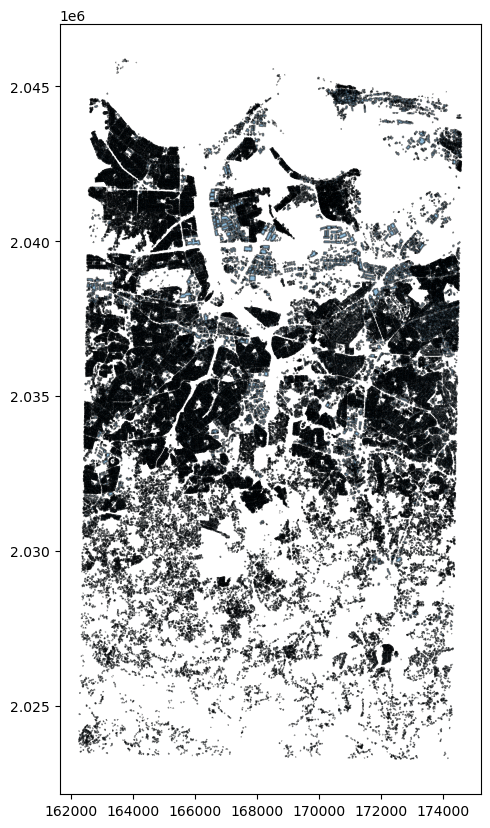

In [18]:
ax = combined_projected.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.get_xlim()

In [4]:
# pre_event_image = 'Pre_Event_San_Juan.tif'
# image_dir = "../datasets/satellite_imagery/maxar_high_resolution/"

In [2]:
additional_dataset = 'building_footprint_roi_challenge.shp'
folder = '../datasets/satellite_imagery/Buildins Footprint ROI'

In [3]:
puerto_rico = geopandas.read_file(os.path.join(folder, additional_dataset))

# puerto_rico.explore()

In [5]:
puerto_rico.head()

,latitude,longitude,area_in_me,confidence,full_plus_,geometry
0,18.448569,-66.146916,None,0.7140,77CMCVX3+C6GP,"POLYGON ((167578.511 2042703.134, 167575.734 2..."
1,18.411424,-66.182499,None,0.8935,77CMCR69+H26R,"POLYGON ((163749.148 2038647.349, 163737.189 2..."
2,18.429443,-66.167636,None,0.8074,77CMCRHJ+QWHP,"POLYGON ((165354.588 2040621.133, 165350.801 2..."
3,18.371113,-66.119793,None,0.8103,77CM9VCJ+C3WG,"POLYGON ((170294.617 2034071.175, 170289.741 2..."
4,18.418506,-66.172524,None,0.8449,77CMCR9G+CX56,"POLYGON ((164821.285 2039417.821, 164806.291 2..."


In [6]:
puerto_rico

,latitude,longitude,area_in_me,confidence,full_plus_,geometry
0,18.448569,-66.146916,None,0.7140,77CMCVX3+C6GP,"POLYGON ((167578.511 2042703.134, 167575.734 2..."
1,18.411424,-66.182499,None,0.8935,77CMCR69+H26R,"POLYGON ((163749.148 2038647.349, 163737.189 2..."
2,18.429443,-66.167636,None,0.8074,77CMCRHJ+QWHP,"POLYGON ((165354.588 2040621.133, 165350.801 2..."
3,18.371113,-66.119793,None,0.8103,77CM9VCJ+C3WG,"POLYGON ((170294.617 2034071.175, 170289.741 2..."
4,18.418506,-66.172524,None,0.8449,77CMCR9G+CX56,"POLYGON ((164821.285 2039417.821, 164806.291 2..."
...,...,...,...,...,...,...
281567,18.438485,-66.119304,None,0.7072,77CMCVQJ+97WF,"POLYGON ((170479.843 2041537.071, 170474.647 2..."
281568,18.417240,-66.164903,None,0.6713,77CMCR8P+V2XC,"POLYGON ((165618.117 2039265.732, 165611.185 2..."
281569,18.396331,-66.119886,None,0.7770,77CM9VWJ+G2Q8,"POLYGON ((170344.030 2036873.416, 170329.004 2..."
281570,18.390318,-66.178915,None,0.8523,77CM9RRC+4CGP,"POLYGON ((164091.330 2036312.981, 164081.023 2..."


In [9]:
puerto_rico.confidence.describe()

count    281572.000000
mean          0.798560
std           0.078203
min           0.650000
25%           0.733700
50%           0.806800
75%           0.864300
max           0.980200
Name: confidence, dtype: float64

In [12]:
puerto_rico[(puerto_rico['confidence'] <= 0.733700)].explore()

In [8]:
puerto_rico[:1000].explore()